## Load the Dataset

In [1]:
import json
import os
import random

from lib.load import extract_data, LEGALBENCH_RAG_PATH


extract_data()

def load_benchmark_corpus(subset="maud"):
    with open(os.path.join(LEGALBENCH_RAG_PATH, "benchmarks", f"{subset}.json")) as f:
        benchmark = json.load(f)['tests']
    
    corpus = {}
    corpus_path = os.path.join(LEGALBENCH_RAG_PATH, "corpus", subset)

    random.seed(42)
    
    for document in random.sample(os.listdir(corpus_path), 5):
        with open(os.path.join(corpus_path, document)) as f:
            corpus[document] = f.read()

    benchmark_sample = []
    for test in benchmark:
        file_path = test["snippets"][0]["file_path"]
        filename = os.path.basename(file_path)
        if filename in corpus:
            benchmark_sample.append(test)
            
    return benchmark_sample, corpus
benchmark, corpus = load_benchmark_corpus()

In [2]:
import re
from typing import List, Tuple

import numpy as np

from langchain_core.documents import Document
from langchain_text_splitters import RecursiveCharacterTextSplitter
from sentence_transformers import SentenceTransformer
from transformers import BitsAndBytesConfig

from lib.util import cleanup


def create_documents(
    texts: list[str],
    metadatas: list[dict],
    model_path: str="Qwen/Qwen3-Embedding-0.6B",
    pad: int=2,
    max_span: int=1000,
):
    model = SentenceTransformer(
        model_path,
        model_kwargs={"quantization_config": BitsAndBytesConfig(load_in_8bit=True)}
    )
    documents = []
    for text, metadata in zip(texts, metadatas):
        chunks = chunk_text(model, text, pad=pad, max_span=max_span)
        # transform chunks into documents
        for start, end in chunks:
            chunk_metadata = dict(metadata)
            chunk_metadata['start_index'] = start
            documents.append(Document(
                page_content=text[start:end],
                metadata=chunk_metadata,
            ))
    del model
    cleanup()
    return documents
        
def chunk_text(
    model,
    text: str,
    pad: int=2,
    max_span: int=1000,
):
    # preprocess setences
    spans = split_to_spans(text)
    windowed_spans = window_spans(spans, pad=pad)
    sentence_blocks = [text[start:end] for start, end in windowed_spans]
    # generate setence embeddings
    embeddings = model.encode(sentence_blocks, show_progress_bar=True)
    cleanup()
    # split chunks
    distances = pairwise_cosine_distances(embeddings)
    chunk_spans = split_recursive(spans, distances, max_span)
    return chunk_spans


def split_to_spans(text: str) -> List[Tuple[int, int]]:
    """
    Splits a text into spans, first by newline characters unconditionally,
    and then by other separators for chunks that are too large.

    Args:
        text: The input string to split.

    Returns:
        A list of tuples, where each tuple is a (start, end) span of a chunk.
    """
    chunk_size = 200

    lines = text.splitlines(keepends=True)
    initial_spans = []
    current_offset = 0
    for line in lines:
        start = current_offset
        end = start + len(line)
        line_content_end = end
        if line.endswith('\n'):
            line_content_end -= 1
        if start < line_content_end:
            initial_spans.append((start, line_content_end))
        current_offset = end

    # Stage 2: For any chunk that is larger than the chunk_size, split it further
    # using the remaining separators.
    remaining_separators = [
        # Sentence boundaries
        r'(?<=[.?!])\s+',
        # Clause boundaries
        # ';',
        # ':', ',',
    ]
    secondary_splitter = RecursiveCharacterTextSplitter(
        separators=remaining_separators,
        chunk_size=chunk_size,
        chunk_overlap=0,
        add_start_index=True,
        is_separator_regex=True,
    )

    final_spans = []
    for start, end in initial_spans:
        chunk_text = text[start:end]
        if len(chunk_text) <= chunk_size:
            if chunk_text.strip():
                final_spans.append((start, end))
        else:
            doc = Document(page_content=chunk_text)
            sub_docs = secondary_splitter.split_documents([doc])
            for sub_doc in sub_docs:
                sub_chunk_start_relative = sub_doc.metadata.get('start_index', 0)
                sub_chunk_text = sub_doc.page_content
                sub_chunk_end_relative = sub_chunk_start_relative + len(sub_chunk_text)
                final_start = start + sub_chunk_start_relative
                final_end = start + sub_chunk_end_relative
                final_spans.append((final_start, final_end))

    return final_spans

def window_spans(spans, pad=2):
    combined_spans = []
    for i in range(len(spans)):
        start = spans[max(0, i - pad)][0]
        end = spans[min(len(spans) - 1, i + pad)][1]
        combined_spans.append((start, end))
    return combined_spans

def pairwise_cosine_distances(embeddings):
    distances = []
    for i in range(len(embeddings) - 1):
        distances.append(1 - embeddings[i] @ embeddings[i + 1])
    return distances

def split_recursive(spans, distances, max_span):
    distances = np.asarray(distances)
    span_spans = []
    def dfs(start, end):
        lo = spans[start][0]
        hi = spans[end - 1][1]
        if (end - start <= 1) or (hi - lo <= max_span):
            span_spans.append((lo, hi))
        else:
            split_idx = start + np.argmax(distances[start:end - 1]) + 1
            dfs(start, split_idx)
            dfs(split_idx, end)
    dfs(0, len(spans))
    return span_spans


names, texts = zip(*corpus.items())
metadatas = [
    {"source_file": name}
    for idx, name in enumerate(names)
]

documents = create_documents(texts, metadatas, max_span=500, pad=1)
documents[:5]

Batches:   0%|          | 0/30 [00:00<?, ?it/s]

Batches:   0%|          | 0/25 [00:00<?, ?it/s]

Batches:   0%|          | 0/34 [00:00<?, ?it/s]

Batches:   0%|          | 0/29 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

[Document(metadata={'source_file': 'Domtar Corporation_Paper Excellence Canada Group.txt', 'start_index': 0}, page_content='\ufeffExhibit 2.1 \n\n\nExecution Version     AGREEMENT AND PLAN OF MERGER \n\n\namong \n\n\nDOMTAR CORPORATION, \n\n\nKARTA HALTEN B.V., \n\n\nand \n\n\nPEARL MERGER SUB INC. \n\n\nand \n\n\nPAPER EXCELLENCE B.V. \n\n\nand \n\n\nHERVEY INVESTMENTS B.V. \n\n\nDated as of May 10, 2021    '),
 Document(metadata={'source_file': 'Domtar Corporation_Paper Excellence Canada Group.txt', 'start_index': 259}, page_content='________________'),
 Document(metadata={'source_file': 'Domtar Corporation_Paper Excellence Canada Group.txt', 'start_index': 278}, page_content='TABLE OF CONTENTS         Page  ARTICLE I    DEFINITIONS    Section 1.1   Definitions    6  Section 1.2   Table of Definitions    20  Section 1.3   Other Definitional and Interpretative Provisions    22  ARTICLE II    THE MERGER; EFFECT ON THE CAPITAL STOCK; PAYMENT    Section 2.1   The Merger    23  Section 2.

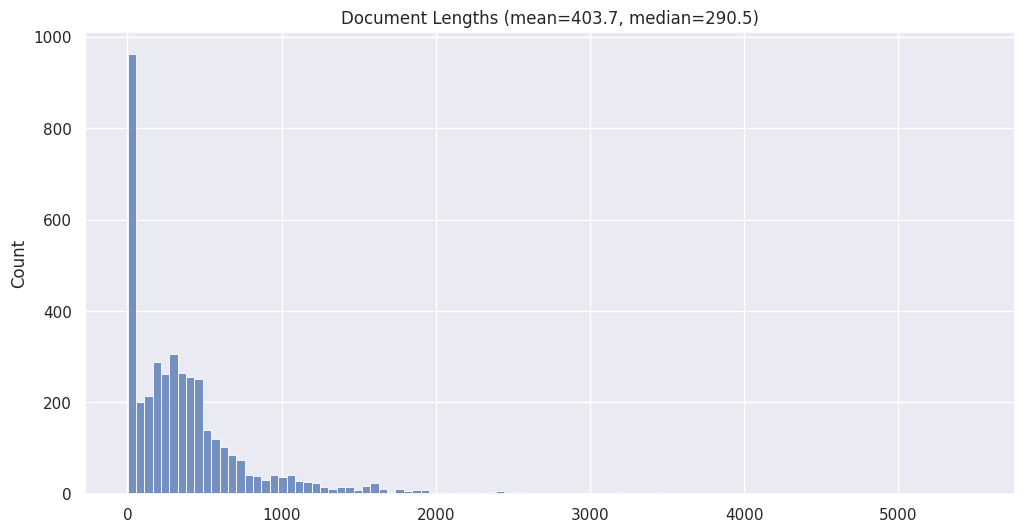

In [3]:
%matplotlib inline

import statistics
import matplotlib.pyplot as plt
import seaborn as sns


sns.set_theme()

lengths = [len(doc.page_content) for doc in documents]

plt.figure(figsize=(12, 6))
sns.histplot(lengths)
plt.title(f"Document Lengths (mean={statistics.mean(lengths):.1f}, median={statistics.median(lengths):.1f})")
plt.show()

In [4]:
def compute_similarities(benchmark, documents):
    # Load model
    model = SentenceTransformer(
        "Qwen/Qwen3-Embedding-0.6B",
        model_kwargs={"quantization_config": BitsAndBytesConfig(load_in_8bit=True)}
    )
    # Compute embeddings
    document_embeddings = model.encode(
        [f"{document.metadata["source_file"]}: {document.page_content}" for document in documents],
        show_progress_bar=True,
    )
    query_embeddings = model.encode(
        [test['query'] for test in benchmark],
        prompt_name="query",
        show_progress_bar=True,
    )
    # Compute similarity
    similarities = model.similarity(query_embeddings, document_embeddings)
    # Cleanup
    del model
    cleanup()

    return similarities

similarities = compute_similarities(benchmark, documents)

Batches:   0%|          | 0/127 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

In [5]:
import torch

from lib.metrics import print_evaluations


ranks = torch.argsort(similarities, descending=True)

print("Baseline Evaluation")
print_evaluations(benchmark, documents, ranks)

Baseline Evaluation
precision @ 1 :  0.2306, recall @ 1 :  0.2072
precision @ 2 :  0.2006, recall @ 2 :  0.2841
precision @ 4 :  0.1227, recall @ 4 :  0.3063
precision @ 8 :  0.0927, recall @ 8 :  0.4007
precision @ 16:  0.0640, recall @ 16:  0.5072
precision @ 32:  0.0428, recall @ 32:  0.6249
precision @ 64:  0.0267, recall @ 64:  0.7230
AUC: 0.07685438425213714


In [6]:
from tqdm.notebook import tqdm
import torch

from lib.rerank import Reranker


model_path = "ContextualAI/ctxl-rerank-v2-instruct-multilingual-2b"
TOP_K = 32

def rerank(benchmark, documents, ranks, model_path=model_path, topk=TOP_K):
    reranker = Reranker(model_path)
    
    results = []
    for idx, (test, doc_idxs) in tqdm(
        enumerate(zip(benchmark, ranks)),
        total=min(len(benchmark), len(ranks))
    ):
        result = reranker(
            query=benchmark[idx]['query'],
            instruction='',
            documents=[
                f"{documents[document_idx].metadata["source_file"]}: {documents[document_idx].page_content}" 
                for document_idx in ranks[idx, :TOP_K]
            ],
        )
        results.append(result)
    
        if idx % 8 == 0:
            cleanup()
    
    reranks = []
    for idx, result in enumerate(results):
        top_documents = ranks[idx, :TOP_K]
        base_document_idxs = [int(top_documents[relative_idx]) for score, relative_idx, content in result]
        reranks.append(base_document_idxs)
    return reranks

ranks = torch.argsort(similarities, descending=True)
reranks = rerank(benchmark, documents, ranks)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

/home/joshuachin/miniconda3/envs/RAG-2/lib/python3.12/site-packages/bitsandbytes/autograd/_functions.py:186: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


In [7]:
print(f"Reranked (K={TOP_K}) Evaluation")
print_evaluations(benchmark, documents, reranks)

Reranked (K=32) Evaluation
precision @ 1 :  0.3556, recall @ 1 :  0.3123
precision @ 2 :  0.2405, recall @ 2 :  0.3308
precision @ 4 :  0.1753, recall @ 4 :  0.4158
precision @ 8 :  0.1211, recall @ 8 :  0.5379
precision @ 16:  0.0718, recall @ 16:  0.5987
precision @ 32:  0.0428, recall @ 32:  0.6249
precision @ 64:  0.0428, recall @ 64:  0.6249
AUC: 0.13294449738755415


In [8]:
max(documents, key=lambda doc: len(doc.page_content))

Document(metadata={'source_file': 'W_R_Grace_Co_40_North_Management_LLC.txt', 'start_index': 282793}, page_content='   “Company Material Adverse Effect” means any fact, circumstance, effect, change, event or development that, individually or in the aggregate, has or would reasonably be expected to have a material adverse effect on the business, properties, assets, liabilities, financial condition or results of operations of the Company and the Company Subsidiaries, taken as a whole; provided that, no fact, circumstance, effect, change, event or development resulting from or arising out of any of the following, individually or in the aggregate, shall constitute or be taken into account in determining whether a Company Material Adverse Effect has occurred: (a) any change generally affecting the industries in which the Company and the Company Subsidiaries operate in the United States or elsewhere (including changes in commodity prices or general market prices generally affecting such indu